# Train and test pipeline

This notebook goes through training and testing a convolutional neural network for handwritten digits reconstruction, taken from the freely available MNIST dataset.

Network topology (which comprehends last layer activation function) can bee freely set, as long as loss function and optimizer used during training cycle. Other free parameters are the name of the model, its description as long as path to which every file related to the model itself is stored.

Note, however, that each topology must be made of three component: an encoder convolutional layer, an encorder linear layer, a decoder linear layer and a decoder convolutional layer. Moreover, encoder layers must be specular with respect to their decoder counterpart.

In [1]:
# Dependencies
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import random
import json
import sys
import os

# PyTorch dependencies
from torch.utils.data import DataLoader
from torch import optim
from torch import nn
import torch

# Custom dependencies
from src.autoencoder import Autoencoder
from src.dataset import MNIST

# Set plotting inline
%matplotlib inline

In [2]:
# Settings
settings = {
    'name': 'one',  # Model name
    'desc': '',  # Model description
    'loss': None, # Loss function
    'optimizer': None,  # Optimizer instance
    'topology': None,  # Topology
    'epochs': None  # Train and test epochs
}

In [3]:
# Enable training
TRAIN_ENABLED = True
SAVE_ENABLED = True

In [4]:
# Paths
MODEL_SETTINGS_PATH = './data/models/{0:}/settings.json'
MODEL_WEIGHTS_PATH = './data/models/{0:}/weights.pth'
MODEL_IMAGES_PATH = './data/models/{0:}/images/{1:}.png'
MNIST_PATH = './data/MNIST.mat'

In [5]:
# Define random seed
RANDOM_SEED = 1
# Set random seed
_ = np.random.seed(RANDOM_SEED)  # For numpy module
_ = torch.manual_seed(RANDOM_SEED)  # For pytorch module

In [6]:
# Define available processors
cpu = torch.device('cpu')  # Get CPU device reference
device = torch.device('cuda') if torch.cuda.is_available() else cpu  # Use GPU if available

## Dataset

Mnist dataset is loaded from provided .mat file, which contains handwritten and rotated digits images. These 28x28 images are stored as linearized 1x784 row vectors, and therefore they must be reshape in two dimensions  in order to apply convolutions over it. 

Reshaping operation is demanded to the MNIST dataset class, as long as loading the image first and access the in a sequential manner, then. Furthermore, it is the class responsible of adding noise to original dataset in order to train autoencoders on more difficult problem settings.

Lastly, MNIST dataset class allows to split the dataset into a train and a test dataset, both returned as MNIST dataset classes, either.

In [7]:
# Define noise parameters
NOISE_GAUSS_MU = 0.5
NOISE_GAUSS_SIGMA = 0.7
NOISE_SALT_PEPPER_PRC = 0.3
NOISE_OCCLUSION_PRC = 0.3

In [8]:
# Retrieve input MNIST dataset
mnist_dataset = MNIST(MNIST_PATH)

# Split input MNIST dataset
train_dataset, test_dataset = MNIST.train_test_split(mnist_dataset, test_size=0.2)

# Add noise to train dataset
output_labels, output_images, input_images = train_dataset.data
train_dataset.add_gaussian_noise(output_labels, output_images, input_images, mu=NOISE_GAUSS_MU, sigma=NOISE_GAUSS_SIGMA)
train_dataset.add_salt_pepper_noise(output_labels, output_images, input_images, prc=NOISE_SALT_PEPPER_PRC)
train_dataset.add_occlusion_noise(output_labels, output_images, input_images, prc=NOISE_OCCLUSION_PRC)
train_dataset.clip(scale=(0.0, 1.0))

# Add noise to test dataset
output_labels, output_images, input_images = test_dataset.data
test_dataset.add_gaussian_noise(output_labels, output_images, input_images, mu=NOISE_GAUSS_MU, sigma=NOISE_GAUSS_SIGMA)
test_dataset.add_salt_pepper_noise(output_labels, output_images, input_images, prc=NOISE_SALT_PEPPER_PRC)
test_dataset.add_occlusion_noise(output_labels, output_images, input_images, prc=NOISE_OCCLUSION_PRC)
test_dataset.clip(scale=(0.0, 1.0))

# Check shapes
print('Original MNIST dataset has %d rows' % len(mnist_dataset))
print('Training dataset, augmented with noise, has %d rows' % len(train_dataset))
print('Test dataset, augmented with noise, has %d rows' % len(test_dataset))

Original MNIST dataset has 60000 rows
Training dataset, augmented with noise, has 192000 rows
Test dataset, augmented with noise, has 48000 rows


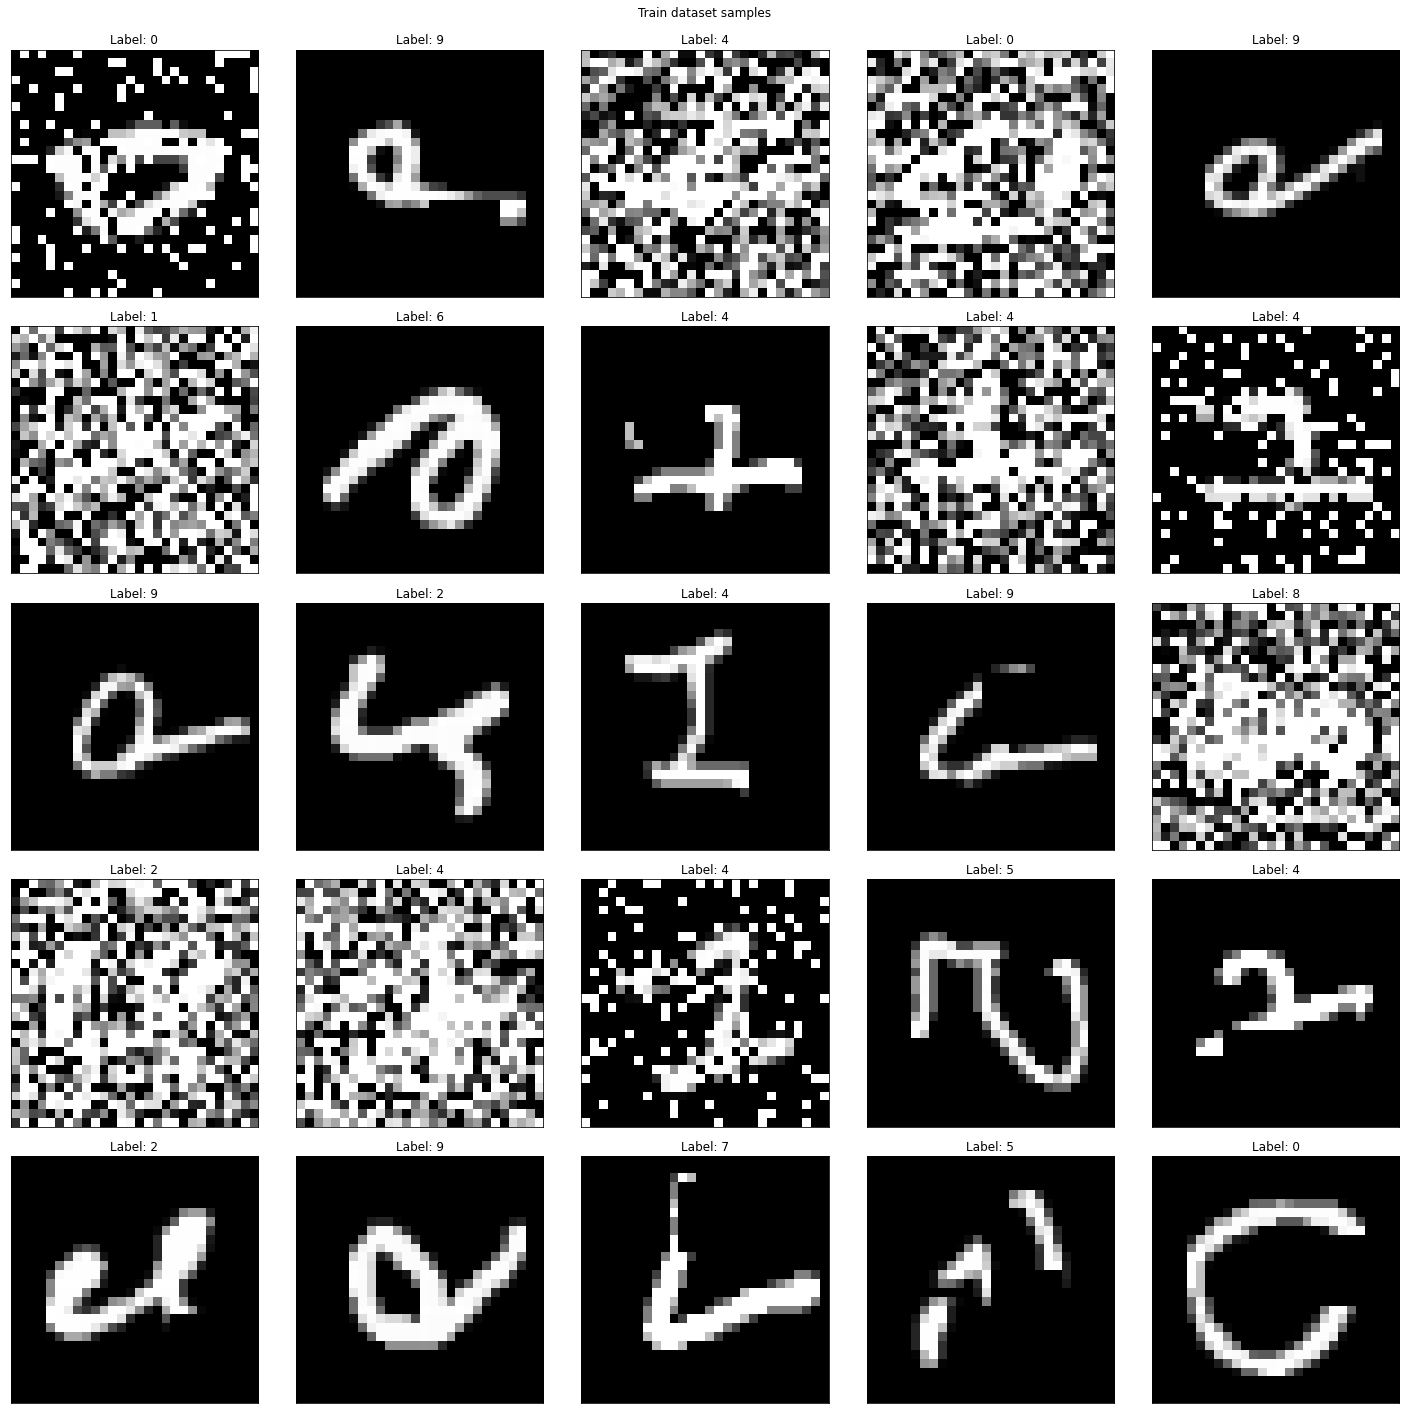

In [9]:
# Plot 10 training samples
fig, axs = plt.subplots(5, 5, figsize=(20, 20))
for ax in axs.flatten():
    # Retrieve a random entry
    out_label, out_image, in_image = random.choice(train_dataset)
    # Show image
    ax.imshow(in_image.squeeze().numpy(), cmap='gist_gray')
    ax.set_title('Label: %d' % out_label)
    ax.set_xticks([])
    ax.set_yticks([])
# Show plot
_ = fig.suptitle('Train dataset samples')
_ = plt.tight_layout()
_ = plt.subplots_adjust(top=0.95)
_ = plt.show()

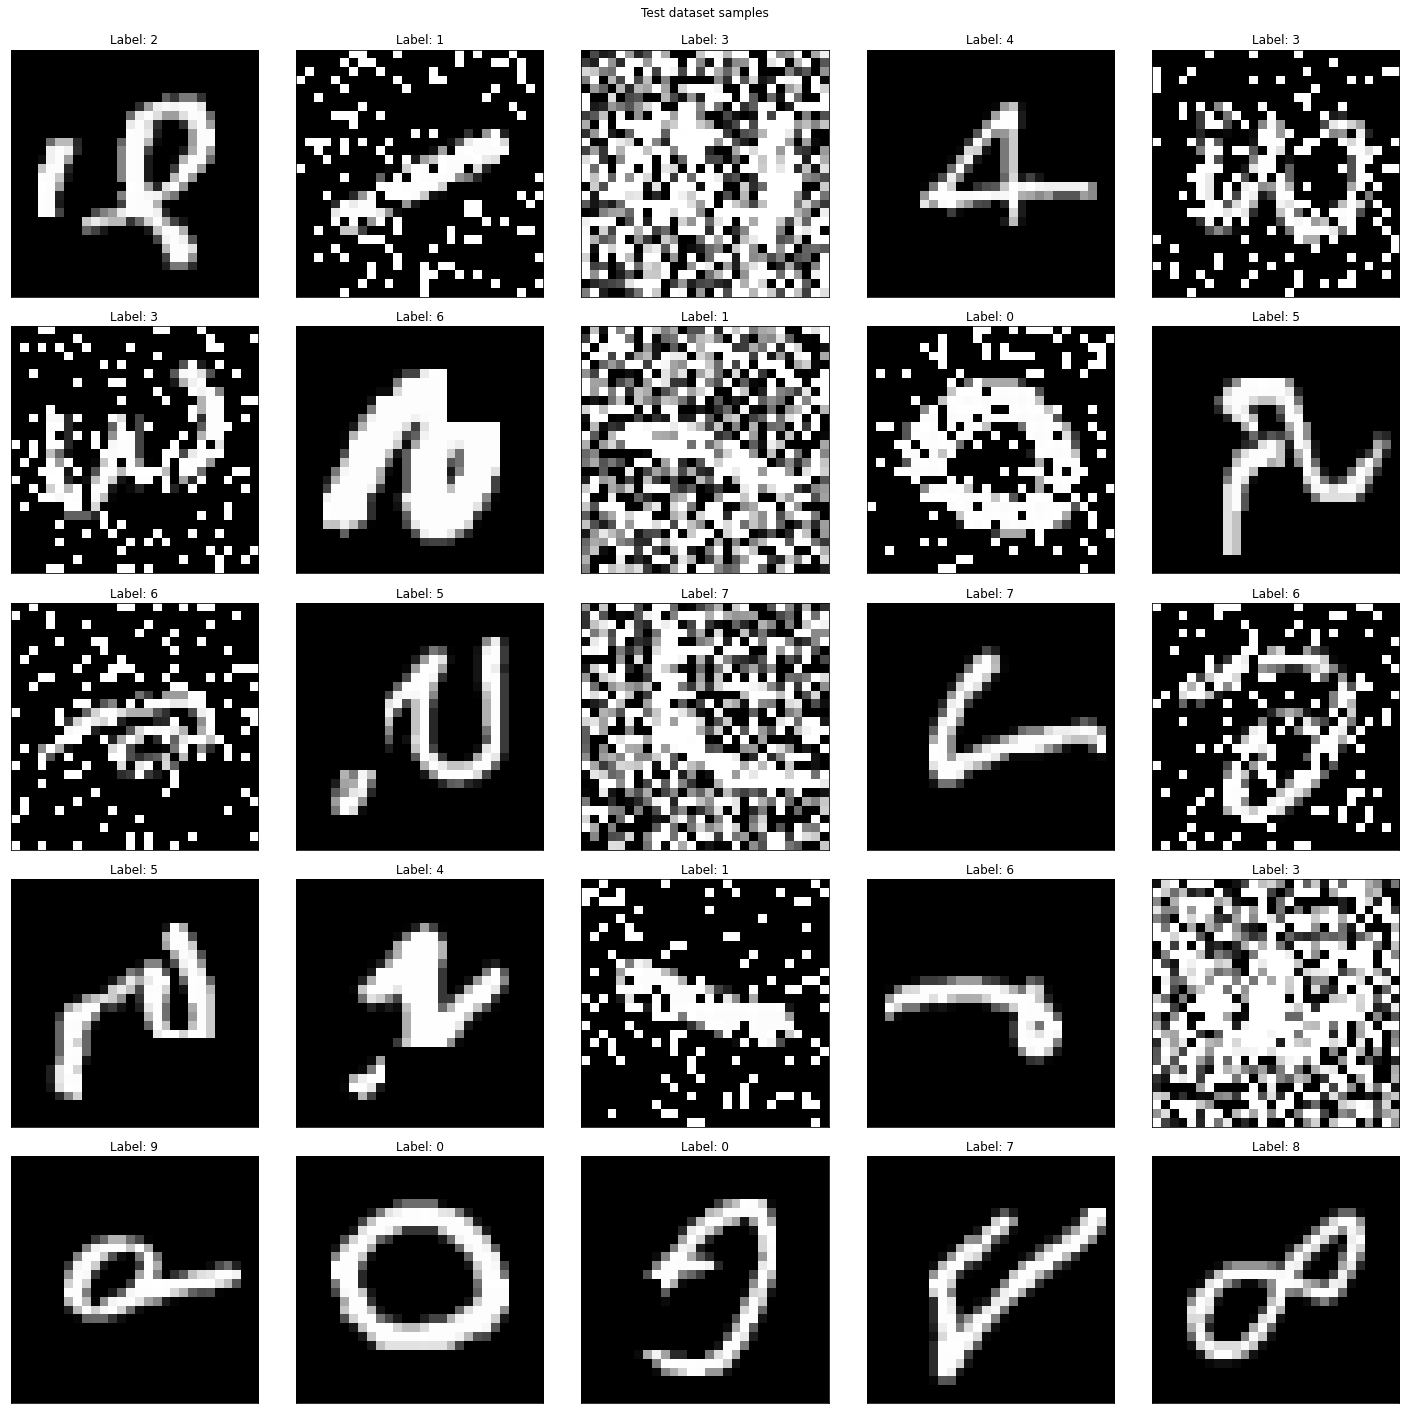

In [10]:
# Plot 10 test samples
fig, axs = plt.subplots(5, 5, figsize=(20, 20))
for ax in axs.flatten():
    # Retrieve a random entry
    out_label, out_image, in_image = random.choice(test_dataset)
    # Show image
    ax.imshow(in_image.squeeze().numpy(), cmap='gist_gray')
    ax.set_title('Label: %d' % out_label)
    ax.set_xticks([])
    ax.set_yticks([])
# Show plot
_ = fig.suptitle('Test dataset samples')
_ = plt.tight_layout()
_ = plt.subplots_adjust(top=0.95)
_ = plt.show()

## Autoencoder

Autoencoder is the neural network responsible of learning handwritten digits reconstruction. Here, its topology is freely modifiable, while it must respect the following constraint: encoder and decoder parts of the autoencoder convolutional neural netowrk, both the convolutional and the linear layers, must be specular.

Training is executed on possibly noised images as input and original, non-noised, images as target output. Moreover, train and test datasets have been split before data augmentation, so there is no bias in the test dataset in any way.

In [11]:
# Define encoder convolutional layer
# NOTE this allows to define linear to convolutionar layer features reshaping
encoder_cnn = nn.Sequential(
    nn.Conv2d(1, 8, 3, stride=2, padding=1),
    nn.ReLU(True),
    nn.Conv2d(8, 16, 3, stride=2, padding=1),
    nn.ReLU(True),
    nn.Conv2d(16, 32, 3, stride=2, padding=0),
    nn.ReLU(True)
)
# Get encoder output on a random 28x28 image, 1 channel)
sample_in = torch.rand(1, 1, 28, 28)
sample_out = encoder_cnn(sample_in)
# Check encoder output
print('Convolutional encoder layer output has shape %s' % str(tuple(sample_out.size())))

Convolutional encoder layer output has shape (1, 32, 3, 3)


In [12]:
# Define linear layer to convolutional reshape
lin_to_cnn = (32, 3, 3)

In [13]:
# Define encoder latent space features
encoded_space_dim = 6

In [14]:
# Define encoder linear layer
encoder_lin = nn.Sequential(
    nn.Linear(3 * 3 * 32, 64),
    nn.ReLU(True),
    nn.Linear(64, encoded_space_dim)
)
# Define decoder linear layer (specular to encoder linear layer)
decoder_lin = nn.Sequential(
    nn.Linear(encoded_space_dim, 64),
    nn.ReLU(True),
    nn.Linear(64, 3 * 3 * 32),
    nn.ReLU(True)
)
# Define decoder convolutional layer (specular to encoder convolutional layer)
decoder_cnn = nn.Sequential(
    nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
    nn.ReLU(True),
    nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
    nn.ReLU(True),
    nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
)

In [15]:
# Set last layer activation function
# NOTE this must be checked with respect to loss function used
# e.g. BCE with logit does not require any activation
last_activation = torch.sigmoid

In [16]:
# Instantiate autoencoder neural network
net = Autoencoder(
    encoder_cnn=encoder_cnn, encoder_lin=encoder_lin,
    decoder_lin=decoder_lin, decoder_cnn=decoder_cnn,
    last_activation=last_activation, lin_to_cnn=lin_to_cnn
)
# Show autoencoder topology
net

Autoencoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU(inplace=True)
  )
  (encoder_lin): Sequential(
    (0): Linear(in_features=288, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=6, bias=True)
  )
  (decoder_lin): Sequential(
    (0): Linear(in_features=6, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (decoder_cnn): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTr

## Training the network

In [17]:
# Define batch size
batch_size=512
# Set dataloaders with given batch size
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
# Define loss function
loss_fn = nn.BCELoss()

In [19]:
# Define optimizer
optimizer = optim.Adam(net.parameters(), lr=3e-3, weight_decay=1e-5)

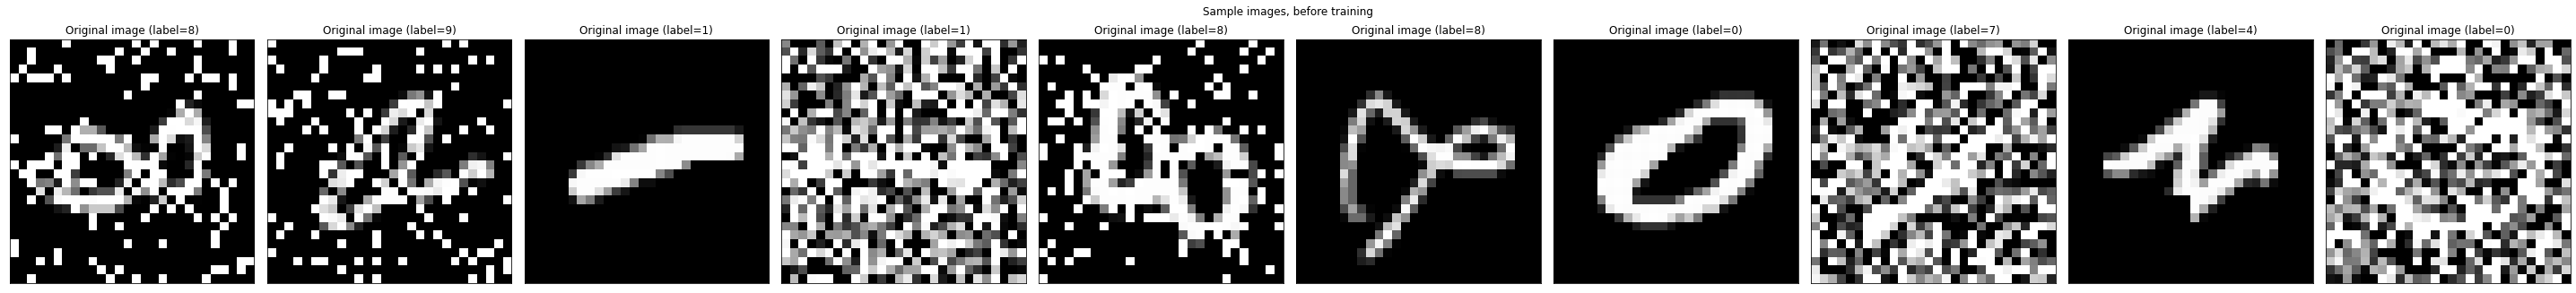

In [20]:
# Define 10 sample images (used to check progress)
test_indices = np.random.choice(len(test_dataset), 10)
# Plot the chosen images
fig, axs = plt.subplots(1, len(test_indices), figsize=(40, 5))
# Loop through each column
for j in range(len(test_indices)):
    # Get a random row in test dataset
    k = test_indices[j]
    # Ret j-th row of test dataset
    out_label, out_image, in_image = test_dataset[k]
    # Reshape input image
    in_image = in_image.unsqueeze(0).to(device)
    # Make original (not noised) image plot
    _ = axs[j].set_title('Original image (label=%d)' % out_label.item())
    _ = axs[j].imshow(in_image.to(cpu).squeeze().numpy(), cmap='gist_gray')
    _ = axs[j].set_xticks([])
    _ = axs[j].set_yticks([])
# Make complete plot
_ = fig.suptitle('Sample images, before training')
_ = plt.subplots_adjust(top=0.95)
_ = plt.tight_layout()
_ = plt.show()

Epoch nr 1, test loss 0.209029
Epoch nr 2, test loss 0.168872
Epoch nr 3, test loss 0.160535
Epoch nr 4, test loss 0.156182
Epoch nr 5, test loss 0.153532
Epoch nr 6, test loss 0.152154
Epoch nr 7, test loss 0.151148
Epoch nr 8, test loss 0.150017
Epoch nr 9, test loss 0.149567
Epoch nr 10, test loss 0.148933
Epoch nr 11, test loss 0.148027
Epoch nr 12, test loss 0.147551
Epoch nr 13, test loss 0.148343
Epoch nr 14, test loss 0.146677
Epoch nr 15, test loss 0.146545
Epoch nr 16, test loss 0.146368
Epoch nr 17, test loss 0.145450
Epoch nr 18, test loss 0.145881
Epoch nr 19, test loss 0.144842
Epoch nr 20, test loss 0.144743
Epoch nr 21, test loss 0.144359
Epoch nr 22, test loss 0.144359
Epoch nr 23, test loss 0.144264
Epoch nr 24, test loss 0.144278
Epoch nr 25, test loss 0.143562
Epoch nr 26, test loss 0.143291
Epoch nr 27, test loss 0.143637
Epoch nr 28, test loss 0.143055
Epoch nr 29, test loss 0.143324
Epoch nr 30, test loss 0.143466
Epoch nr 31, test loss 0.142699
Epoch nr 32, test

KeyboardInterrupt: 

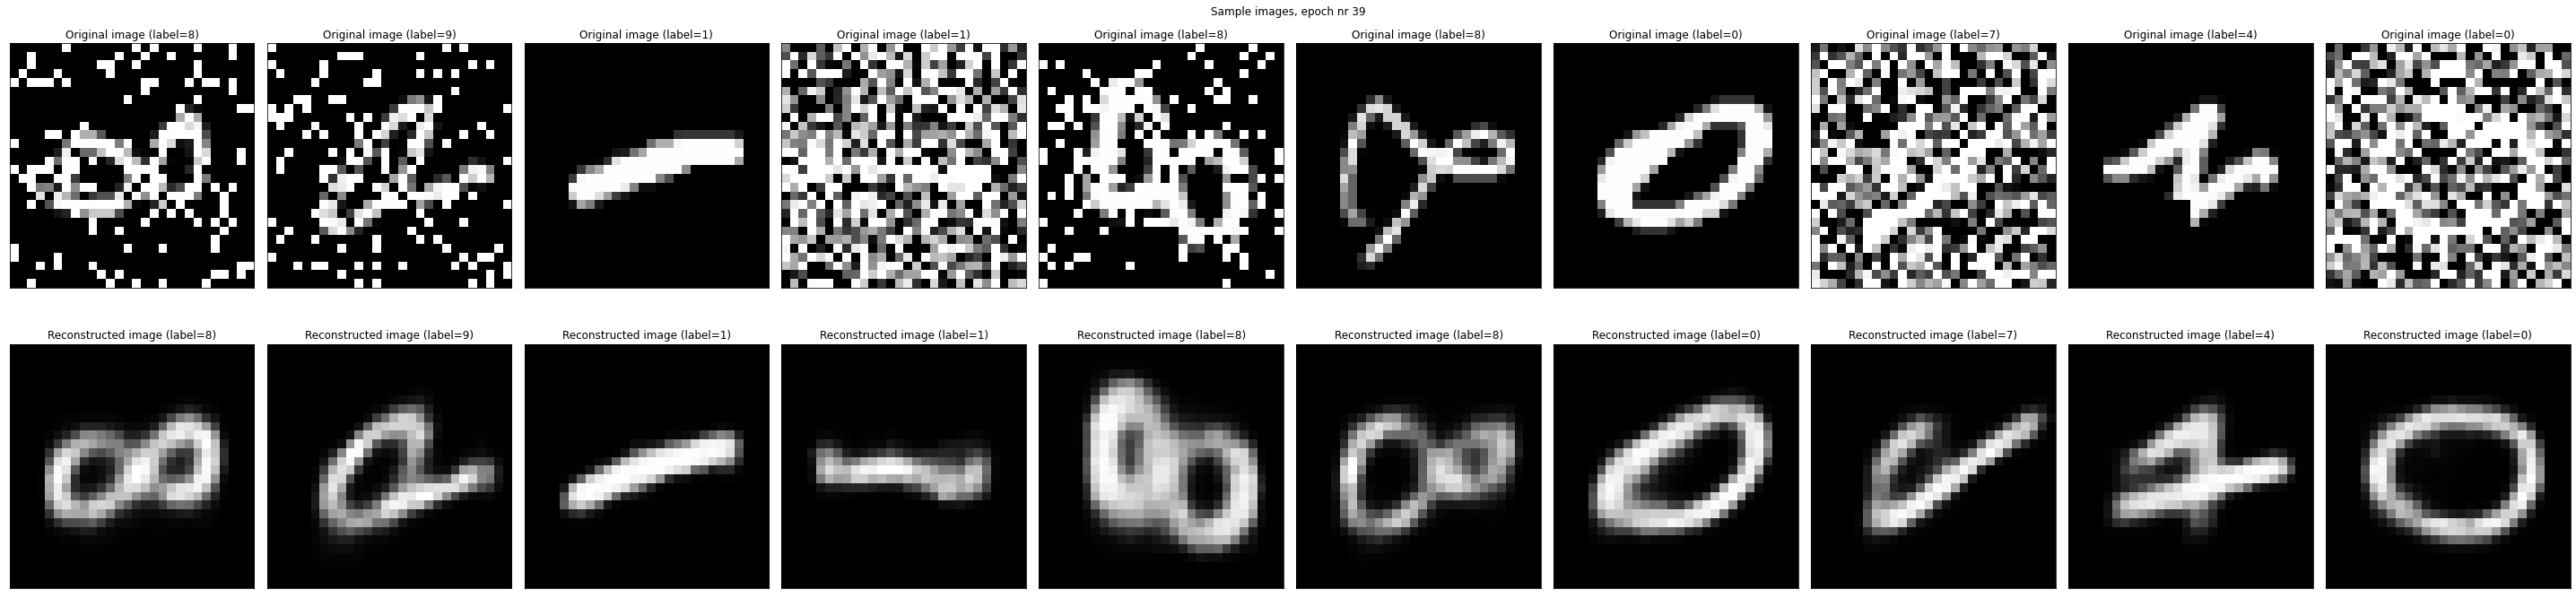

In [21]:
# Define number of epochs
num_epochs = 100

# Move all the network parameters to the selected device
# NOTE if parameters are already on that device, nothing happens
net = net.to(device)

# Initialize epochs output container
out_epochs = {
    'train_epochs': list(),
    'test_epochs': list(),
    'num_epochs': num_epochs
}

# Initialize epochs iterator
iter_epochs = tqdm(range(num_epochs))
# Execute train and test loop
for epoch in iter_epochs:
    # Print current epoch
    # print('Epochs %d/%d' % (epoch + 1, num_epochs))
    
    ### Training
    train_losses = net.train_epoch(dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, device=device)
    # Save train partial losses
    out_epochs['train_epochs'].extend(train_losses)
    
    ### Validation
    test_loss = net.test_epoch(dataloader=test_dataloader, loss_fn=loss_fn, optimizer=optimizer, device=device)
    # Print validation loss
    iter_epochs.write('Epoch nr %d, test loss %f' % (epoch + 1, test_loss))
    # print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))
    # Save train partial losses
    out_epochs['test_epochs'].append(test_loss)
    
    
    ### Plot progress
    # Initialize plot
    fig, axs = plt.subplots(2, len(test_indices), figsize=(40, 10))
    # Loop through each column
    for j in range(len(test_indices)):
        # Get a random row in test dataset
        k = test_indices[j]
        # Ret j-th row of test dataset
        out_label, out_image, in_image = test_dataset[k]
        # Reshape input image
        in_image = in_image.unsqueeze(0).to(device)
        # Set the network in evaluation mode
        net.eval()
        with torch.no_grad():
            # Make prediction
            pred_image = net(in_image)
        # Make original (not noised) image plot
        _ = axs[0, j].set_title('Original image (label=%d)' % out_label.item())
        _ = axs[0, j].imshow(in_image.to(cpu).squeeze().numpy(), cmap='gist_gray')
        _ = axs[0, j].set_xticks([])
        _ = axs[0, j].set_yticks([])
        # Make reconstructed image plot
        _ = axs[1, j].set_title('Reconstructed image (label=%d)' % out_label.item())
        _ = axs[1, j].imshow(pred_image.to(cpu).squeeze().numpy(), cmap='gist_gray')
        _ = axs[1, j].set_xticks([])
        _ = axs[1, j].set_yticks([])
    # Make complete plot
    _ = fig.suptitle('Sample images, epoch nr %d' % (epoch + 1))
    _ = plt.tight_layout()
    # Save figures
    _ = os.makedirs(MODEL_IMAGES_PATH.format(settings['name'], ''), exist_ok=True)
    _ = plt.savefig(MODEL_IMAGES_PATH.format(settings['name'], 'epoch{:03d}'.format(epoch + 1)))
    _ = plt.close()

    # Save network parameters
    _ = torch.save(net.state_dict(), MODEL_WEIGHTS_PATH.format(settings['name']))
    # Save model settings
    with open(MODEL_SETTINGS_PATH.format(settings['name']), 'w') as settings_file:
        # Dump settings to json file
        json.dump(fp=settings_file, obj={
            'name': settings['name'],
            'desc': settings['desc'],
            'loss': str(loss_fn),
            'optimizer': str(optimizer),
            'topology': str(net),
            'epochs': out_epochs
        })

## Network analysis

In [ ]:
# Load settings from disk
with open(MODEL_SETTINGS_PATH.format(settings['name']), 'r') as settings_file:
    # Load json
    settings = json.load(settings_file)
    # Print settings
    print(json.dumps(settings, indent=True))

In [ ]:
# Load neural network to cpu
net = net.to(cpu)
net = net.load_state_dict(torch.load(MODEL_WEIGHTS_PATH.format(settings['name']),  map_location='cpu'))  

In [ ]:
# Get the encoded representation of the test samples

# Initialize encoded samples list
encoded_samples = list()
# Go through each image in test dataset, one by one
for sample in tqdm(test_dataset):
    # Get a sample in test dataset
    out_label, out_image, in_image = sample
    in_image = in_image.unsqueeze(0)
    # Set neural network to evaluation mode
    net.eval()
    with torch.no_grad():
        # ENcode the image
        encoded_image  = net.encode(in_image)
    # Append to list
    encoded_samples.append((encoded_image.flatten().numpy(), out_label.item()))
    
# Define a color for each digit
color_map = {
    0: '#1f77b4',
    1: '#ff7f0e',
    2: '#2ca02c',
    3: '#d62728',
    4: '#9467bd',
    5: '#8c564b',
    6: '#e377c2',
    7: '#7f7f7f',
    8: '#bcbd22',
    9: '#17becf'
}

# Sample 1k points from the latent space
encoded_samples_reduced = random.sample(encoded_samples, 1000)
# Make plot of the sampled points
_ = plt.figure(figsize=(12,10))
# Plot each point
for enc_sample, label in tqdm(encoded_samples_reduced):
    _ = plt.plot(enc_sample[0], enc_sample[1], marker='.', color=color_map[label])
# Show plot
_ = plt.grid(True)
_ = plt.legend([plt.Line2D([0], [0], ls='', marker='.', color=c, label=l) for l, c in color_map.items()], color_map.keys())
_ = plt.tight_layout()
_ = plt.show()